## TransE TRAIN

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, entity_embedding_dim, relation_embedding_dim):
        super(TransE, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.entity_embedding_dim = entity_embedding_dim
        self.relation_embedding_dim = relation_embedding_dim
        
        self.entity_embeddings = nn.Embedding(num_entities, entity_embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, relation_embedding_dim)

    def forward(self, pos_head, pos_tail, pos_relation, neg_head, neg_tail, neg_relation):
        pos_head_embed = self.entity_embeddings(pos_head)
        pos_tail_embed = self.entity_embeddings(pos_tail)
        pos_relation_embed = self.relation_embeddings(pos_relation)

        neg_head_embed = self.entity_embeddings(neg_head)
        neg_tail_embed = self.entity_embeddings(neg_tail)
        neg_relation_embed = self.relation_embeddings(neg_relation)

        pos_score = torch.norm(pos_head_embed + pos_relation_embed - pos_tail_embed, p=1, dim=1)
        neg_score = torch.norm(neg_head_embed + neg_relation_embed - neg_tail_embed, p=1, dim=1)

        return pos_score, neg_score


def generate_training_data(num_entities, num_relations, num_triples):
    # Generate positive triples (subject, relation, object)
    pos_triples = np.random.randint(1, num_entities, size=(num_triples, 3)) 
    neg_triples = np.copy(pos_triples)
    head_or_tail = np.random.randint(0, 2, size=(num_triples))
    random_entities = np.random.randint(1, num_entities, size=(num_triples)) 
    neg_triples[np.arange(num_triples), head_or_tail] = random_entities
    neg_triples[:, 1] = np.random.randint(0, num_relations, size=(num_triples))
    pos_triples[:, 1] = np.random.randint(0, num_relations, size=(num_triples))
    return torch.LongTensor(pos_triples), torch.LongTensor(neg_triples)

def create_entity_and_relation_mappings(data):
    entities = data['Date'].astype(str).tolist() # We will not include 'Date' as an entity
    attributes = list(data.columns)
    attributes.remove('Date')
    
    relations = ['has_' + attr for attr in attributes]
    entity2id = {entity: idx for idx, entity in enumerate(entities)}
    relation2id = {relation: idx for idx, relation in enumerate(relations)}

    num_entities = len(entity2id)
    num_relations = len(relation2id)

    return entity2id, relation2id, num_entities, num_relations

def data_to_numerical_ids(data, entity2id, relation2id):
    data['Date_id'] = [entity2id[date] for date in data['Date'].astype(str)]

    for attr in data.columns[1:]:
        relation = 'has_' + attr
        data[relation] = relation2id[relation]
        data[relation + '_id'] = data[relation] + 1

    # Drop the 'Date' column as it's not needed anymore
    data = data.drop(columns=['Date'])

    return data

def train_transE(model, num_entities, num_relations, num_triples, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MarginRankingLoss(margin=1.0)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pos_triples, neg_triples = generate_training_data(num_entities, num_relations, num_triples)

        pos_triples = pos_triples.long()
        neg_triples = neg_triples.long()

        max_entity_idx = max(torch.max(pos_triples), torch.max(neg_triples))
        max_relation_idx = max(torch.max(pos_triples[:, 1]), torch.max(neg_triples[:, 1]))

        assert max_entity_idx < num_entities, f"Entity index exceeds the allowed range: {max_entity_idx} >= {num_entities}"
        assert max_relation_idx < num_relations, f"Relation index exceeds the allowed range: {max_relation_idx} >= {num_relations}"

        pos_head, pos_relation, pos_tail = pos_triples[:, 0], pos_triples[:, 1], pos_triples[:, 2]
        neg_head, neg_relation, neg_tail = neg_triples[:, 0], neg_triples[:, 1], neg_triples[:, 2]

        pos_score, neg_score = model(pos_head, pos_tail, pos_relation, neg_head, neg_tail, neg_relation)
        y_pos = torch.ones(num_triples)
        y_neg = -torch.ones(num_triples)
        loss = loss_fn(pos_score, neg_score, y_pos + 0.1)  # Add 0.1 margin to positive scores
        loss += loss_fn(neg_score, pos_score, y_neg - 0.1)  # Add 0.1 margin to negative scores

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

if __name__ == "__main__":
    data = pd.read_csv("UsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential",  "Hospitalization", "Death" ])
    data["Date"] = pd.to_datetime(data["Date"])
    data.sort_values("Date", inplace=True)

    data = data.tail(208)
    print(data)


    # Now 'data_first_168' contains only the first 168 dates and data points

    entity2id, relation2id, num_entities, num_relations = create_entity_and_relation_mappings(data)

    print(num_entities)

    print(num_relations)
   # data_numerical = data_to_numerical_ids(data, entity2id, relation2id)

    entity_embedding_dim = 8
    relation_embedding_dim = 8
    model = TransE(num_entities, num_relations, entity_embedding_dim, relation_embedding_dim)

    num_triples = 500
    num_epochs = 5000
    learning_rate = 0.001
    train_transE(model, num_entities, num_relations, num_triples, num_epochs, learning_rate)

    entity_embeddings = model.entity_embeddings.weight.data.numpy()
    relation_embeddings = model.relation_embeddings.weight.data.numpy()


          Date  RetailRecreation  GroceryPharmacy  Parks  Transit  Workplace  \
10  2022-01-31               -15               -4    -13      -30        -23   
11  2022-02-01               -10                4     -8      -28        -23   
12  2022-02-02               -17               -4    -15      -31        -26   
13  2022-02-03               -25              -12    -19      -36        -33   
14  2022-02-04               -23              -15    -22      -35        -31   
..         ...               ...              ...    ...      ...        ...   
213 2022-08-22                -9               -2     25      -22        -28   
214 2022-08-23                -8                0     37      -20        -27   
215 2022-08-24                -7               -1     38      -20        -26   
216 2022-08-25                -7               -1     41      -20        -26   
217 2022-08-26                -9               -4     35      -20        -26   

     Residential  Hospitalization   Dea

## TransE TEST

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, entity_embedding_dim, relation_embedding_dim):
        super(TransE, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.entity_embedding_dim = entity_embedding_dim
        self.relation_embedding_dim = relation_embedding_dim
        
        self.entity_embeddings = nn.Embedding(num_entities, entity_embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, relation_embedding_dim)

    def forward(self, pos_head, pos_tail, pos_relation, neg_head, neg_tail, neg_relation):
        pos_head_embed = self.entity_embeddings(pos_head)
        pos_tail_embed = self.entity_embeddings(pos_tail)
        pos_relation_embed = self.relation_embeddings(pos_relation)

        neg_head_embed = self.entity_embeddings(neg_head)
        neg_tail_embed = self.entity_embeddings(neg_tail)
        neg_relation_embed = self.relation_embeddings(neg_relation)

        pos_score = torch.norm(pos_head_embed + pos_relation_embed - pos_tail_embed, p=1, dim=1)
        neg_score = torch.norm(neg_head_embed + neg_relation_embed - neg_tail_embed, p=1, dim=1)

        return pos_score, neg_score


def generate_training_data(num_entities, num_relations, num_triples):
    # Generate positive triples (subject, relation, object)
    pos_triples = np.random.randint(1, num_entities, size=(num_triples, 3)) 
    neg_triples = np.copy(pos_triples)
    head_or_tail = np.random.randint(0, 2, size=(num_triples))
    random_entities = np.random.randint(1, num_entities, size=(num_triples)) 
    neg_triples[np.arange(num_triples), head_or_tail] = random_entities
    neg_triples[:, 1] = np.random.randint(0, num_relations, size=(num_triples))
    pos_triples[:, 1] = np.random.randint(0, num_relations, size=(num_triples))
    return torch.LongTensor(pos_triples), torch.LongTensor(neg_triples)

def create_entity_and_relation_mappings(data):
    entities = data['Date'].astype(str).tolist() # We will not include 'Date' as an entity
    attributes = list(data.columns)
    attributes.remove('Date')
    
    relations = ['has_' + attr for attr in attributes]
    entity2id = {entity: idx for idx, entity in enumerate(entities)}
    relation2id = {relation: idx for idx, relation in enumerate(relations)}

    num_entities = len(entity2id)
    num_relations = len(relation2id)

    return entity2id, relation2id, num_entities, num_relations

def data_to_numerical_ids(data, entity2id, relation2id):
    data['Date_id'] = [entity2id[date] for date in data['Date'].astype(str)]

    for attr in data.columns[1:]:
        relation = 'has_' + attr
        data[relation] = relation2id[relation]
        data[relation + '_id'] = data[relation] + 1

    # Drop the 'Date' column as it's not needed anymore
    data = data.drop(columns=['Date'])

    return data

def train_transET(model, num_entities, num_relations, num_triples, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MarginRankingLoss(margin=1.0)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pos_triples, neg_triples = generate_training_data(num_entities, num_relations, num_triples)

        pos_triples = pos_triples.long()
        neg_triples = neg_triples.long()

        max_entity_idx = max(torch.max(pos_triples), torch.max(neg_triples))
        max_relation_idx = max(torch.max(pos_triples[:, 1]), torch.max(neg_triples[:, 1]))

        assert max_entity_idx < num_entities, f"Entity index exceeds the allowed range: {max_entity_idx} >= {num_entities}"
        assert max_relation_idx < num_relations, f"Relation index exceeds the allowed range: {max_relation_idx} >= {num_relations}"

        pos_head, pos_relation, pos_tail = pos_triples[:, 0], pos_triples[:, 1], pos_triples[:, 2]
        neg_head, neg_relation, neg_tail = neg_triples[:, 0], neg_triples[:, 1], neg_triples[:, 2]

        pos_score, neg_score = model(pos_head, pos_tail, pos_relation, neg_head, neg_tail, neg_relation)
        y_pos = torch.ones(num_triples)
        y_neg = -torch.ones(num_triples)
        loss = loss_fn(pos_score, neg_score, y_pos + 0.1)  # Add 0.1 margin to positive scores
        loss += loss_fn(neg_score, pos_score, y_neg - 0.1)  # Add 0.1 margin to negative scores

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

if __name__ == "__main__":
    data = pd.read_csv("TestUsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential",  "Hospitalization", "Death" ])
    data["Date"] = pd.to_datetime(data["Date"])
    data.sort_values("Date", inplace=True)

    data = data.tail(40)


    # Now 'data_first_168' contains only the first 168 dates and data points

    entity2idT, relation2idT, num_entitiesT, num_relationsT = create_entity_and_relation_mappings(data)

    print(num_entitiesT)

    print(num_relationsT)
   # data_numerical = data_to_numerical_ids(data, entity2id, relation2id)

    entity_embedding_dim = 8
    relation_embedding_dim = 8
    model = TransE(num_entitiesT, num_relationsT, entity_embedding_dim, relation_embedding_dim)

    num_triples = 500
    num_epochs = 5000
    learning_rate = 0.001
    train_transET(model, num_entitiesT, num_relationsT, num_triples, num_epochs, learning_rate)

    entity_embeddingsT = model.entity_embeddings.weight.data.numpy()
    relation_embeddingsT = model.relation_embeddings.weight.data.numpy()


40
8
Epoch: 0, Loss: 4.787337303161621
Epoch: 100, Loss: 4.1145195960998535
Epoch: 200, Loss: 4.0332112312316895
Epoch: 300, Loss: 3.716083526611328
Epoch: 400, Loss: 3.381166458129883
Epoch: 500, Loss: 3.3263134956359863
Epoch: 600, Loss: 3.00315523147583
Epoch: 700, Loss: 3.2864649295806885
Epoch: 800, Loss: 3.102210283279419
Epoch: 900, Loss: 2.978832244873047
Epoch: 1000, Loss: 2.9920668601989746
Epoch: 1100, Loss: 2.719644546508789
Epoch: 1200, Loss: 2.9296212196350098
Epoch: 1300, Loss: 2.6050925254821777
Epoch: 1400, Loss: 2.6662709712982178
Epoch: 1500, Loss: 2.359752893447876
Epoch: 1600, Loss: 2.510054111480713
Epoch: 1700, Loss: 2.2273483276367188
Epoch: 1800, Loss: 2.2447729110717773
Epoch: 1900, Loss: 2.1599926948547363
Epoch: 2000, Loss: 2.221461296081543
Epoch: 2100, Loss: 2.1097686290740967
Epoch: 2200, Loss: 2.2301018238067627
Epoch: 2300, Loss: 2.082007646560669
Epoch: 2400, Loss: 2.1283249855041504
Epoch: 2500, Loss: 2.2043404579162598
Epoch: 2600, Loss: 2.0786690711

## RNN Model

In [54]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, entity_embedding_dim, relation_embedding_dim):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.entity_embedding_dim = entity_embedding_dim
        self.relation_embedding_dim = relation_embedding_dim

        # Create an embedding layer for the entities
        self.entity_embedding_layer = nn.Embedding(input_size, entity_embedding_dim)
        # Create an embedding layer for the relations
        self.relation_embedding_layer = nn.Embedding(input_size, relation_embedding_dim)

        # The combined input size of the RNN will include the entity and relation embeddings
        combined_input_size = input_size + entity_embedding_dim + relation_embedding_dim

        self.rnn = nn.RNN(combined_input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, entity_embeddings, relation_embeddings):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Expand entity and relation embeddings to match the shape of input_sequences
        expanded_entity_embeddings = entity_embeddings.unsqueeze(1).expand(-1, x.size(1), -1)
        expanded_relation_embeddings = relation_embeddings.unsqueeze(0).expand(x.size(0), -1, -1)

        # Concatenate the input x with the expanded entity and relation embeddings
        rnn_input = torch.cat([x, expanded_entity_embeddings, expanded_relation_embeddings], dim=-1)

        out, _ = self.rnn(rnn_input, h0[:, :x.size(0), :])
        out = self.fc(out[:, -1, :])
        return out

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





## Train RNN

In [55]:
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def smape(y, y_pred):
    """ 
    A function to calculate the symmetric mean absolute percentage error (sMAPE).

    Arguments
    ----------
    y: np.ndarray
        the response data
    y_pred: np.ndarray
        the predicted/forecasted outputs
        
    Returned Values
    ----------
    sMAPE : float

    """   
    return 200 * torch.sum(torch.abs(y-y_pred) / (torch.abs(y) + torch.abs(y_pred))) / len(y)

def mae(y, y_pred) :
    """ 
    A function to calculate the mean absolute error (MAE).

    Arguments
    ----------
    y: np.ndarray
        the response data
    y_pred: np.ndarray
        the predicted/forecasted outputs
        
    Returned Values
    ----------
    MAE : float

    """   
    return torch.sum(torch.abs(y-y_pred))/len(y)

def sst(y) :
    """ 
    A function to calculate the sum of squares total (SST).

    Arguments
    ----------
    y: np.ndarray
        the response data
        
    Returned Values
    ----------
    SST : float
    """ 
    return torch.sum((y-torch.mean(y))**2)

def sse(y, y_pred) :
    """ 
    A function to calculate the sum of squared errors (SSE).

    Arguments
    ----------
    y: np.ndarray
        the response data
    y_pred: np.ndarray
        the predicted/forecasted outputs
        
    Returned Values
    ----------
    SSE : float

    """   
    return torch.sum((y-y_pred)**2)

def r2(y, y_pred) :
    """ 
    A function to calculate R squared (r2).

    Arguments
    ----------
    y: np.ndarray
        the response data
    y_pred: np.ndarray
        the predicted/forecasted outputs
        
    Returned Values
    ----------
    r2 : float

    """   
    return 1-sse(y, y_pred)/sst(y)


def mse(y, y_pred):
   # return torch.mean((y - y_pred)**2)
    return sse(y, y_pred)/len(y)


def rmse(y, y_pred):
    return torch.sqrt(mse(y, y_pred))
# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
dataComp = pd.read_csv("UsCovidDatacomplete.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

# Convert the "Date" column to a pandas DateTime object
dataComp["Date"] = pd.to_datetime(dataComp["Date"])

# Sort the data by date if it's not already sorted
dataComp.sort_values("Date", inplace=True)

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
data = pd.read_csv("UsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

# Convert the "Date" column to a pandas DateTime object
data["Date"] = pd.to_datetime(data["Date"])

# Sort the data by date if it's not already sorted
data.sort_values("Date", inplace=True)

# Extract the values as numpy arrays

RetailRecreation = data["RetailRecreation"].values.astype(float)
GroceryPharmacy = data["GroceryPharmacy"].values.astype(float)
Parks = data["Parks"].values.astype(float)
Transit = data["Transit"].values.astype(float)
Workplace = data["Workplace"].values.astype(float)
Residential = data["Residential"].values.astype(float)
Hospitalization = data["Hospitalization"].values.astype(float)
Death = data["Death"].values.astype(float)

# Normalize the data
normalized_RetailRecreation = (RetailRecreation - np.mean(RetailRecreation)) / np.std(RetailRecreation)
normalized_GroceryPharmacy = (GroceryPharmacy - np.mean(GroceryPharmacy)) / np.std(GroceryPharmacy)
normalized_Parks = (Parks - np.mean(Parks)) / np.std(Parks)
normalized_Transit = (Transit - np.mean(Transit)) / np.std(Transit)
normalized_Workplace = (Workplace - np.mean(Workplace)) / np.std(Workplace)
normalized_Residential = (Residential - np.mean(Residential)) / np.std(Residential)
normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
normalized_Death = (Death - np.mean(Death)) / np.std(Death)

# Define the sequence length and number of features
sequence_length = 10 # Number of previous days to consider
buffer_days = 0
num_features = 8  # Number of input features (Value1 and Value2)

# Create input sequences and corresponding targets
input_sequences = []
targets = []

## all input - sequence length last days
for i in range(len(normalized_RetailRecreation) - sequence_length):
    seq = np.array([normalized_RetailRecreation[i:i+sequence_length], normalized_GroceryPharmacy[i:i+sequence_length], 
                    normalized_Parks[i:i+sequence_length], normalized_Transit[i:i+sequence_length], 
                    normalized_Workplace[i:i+sequence_length], normalized_Residential[i:i+sequence_length], 
                    normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
    input_sequences.append(seq)
    targets.append([normalized_RetailRecreation[i+sequence_length], normalized_GroceryPharmacy[i+sequence_length], 
                    normalized_Parks[i+sequence_length], normalized_Transit[i+sequence_length], 
                    normalized_Workplace[i+sequence_length], normalized_Residential[i+sequence_length], 
                    normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])

# Convert the input sequences and targets to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()
print(input_sequences.shape)
targets = torch.tensor(targets).float()
print(targets.shape)

##----------------------------------------------

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
dataTest = pd.read_csv("TestUsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])
# Convert the "Date" column to a pandas DateTime object
dataTest["Date"] = pd.to_datetime(dataTest["Date"])

# Sort the data by date if it's not already sorted
dataTest.sort_values("Date", inplace=True)

# Extract the values as numpy arrays
RetailRecreationTest = dataTest["RetailRecreation"].values.astype(float)
GroceryPharmacyTest = dataTest["GroceryPharmacy"].values.astype(float)
ParksTest = dataTest["Parks"].values.astype(float)
TransitTest = dataTest["Transit"].values.astype(float)
WorkplaceTest = dataTest["Workplace"].values.astype(float)
ResidentialTest = dataTest["Residential"].values.astype(float)
HospitalizationTest = dataTest["Hospitalization"].values.astype(float)
DeathTest = dataTest["Death"].values.astype(float)

# Normalize the data
normalized_RetailRecreationTest = (RetailRecreationTest - np.mean(RetailRecreationTest)) / np.std(RetailRecreationTest)
normalized_GroceryPharmacyTest = (GroceryPharmacyTest - np.mean(GroceryPharmacyTest)) / np.std(GroceryPharmacyTest)
normalized_ParksTest = (ParksTest - np.mean(ParksTest)) / np.std(ParksTest)
normalized_TransitTest = (TransitTest - np.mean(TransitTest)) / np.std(TransitTest)
normalized_WorkplaceTest = (WorkplaceTest - np.mean(WorkplaceTest)) / np.std(WorkplaceTest)
normalize_ResidentialTest = (ResidentialTest - np.mean(ResidentialTest)) / np.std(ResidentialTest)
normalized_HospitalizationTest = (HospitalizationTest - np.mean(HospitalizationTest)) / np.std(HospitalizationTest)
normalized_DeathTest = (DeathTest - np.mean(DeathTest)) / np.std(DeathTest)

# Define the sequence length and number of features
# Create input sequences and corresponding targets
input_sequencesTest = []
targetsTest = []

## all input - sequence length last days
for j in range(len(normalized_HospitalizationTest) - (sequence_length) ):
    seqTest = np.array([
                    normalized_RetailRecreationTest[j:j+sequence_length], normalized_GroceryPharmacyTest[j:j+sequence_length], 
                    normalized_ParksTest[j:j+sequence_length], normalized_TransitTest[j:j+sequence_length], 
                    normalized_WorkplaceTest[j:j+sequence_length], normalize_ResidentialTest[j:j+sequence_length] ,
                    normalized_HospitalizationTest[j:j+sequence_length], normalized_DeathTest[j:j+sequence_length],  ])

    input_sequencesTest.append(seqTest)
    targetsTest.append([
                    normalized_RetailRecreationTest[j+sequence_length], normalized_GroceryPharmacyTest[j+sequence_length], 
                    normalized_ParksTest[j+sequence_length], normalized_TransitTest[j+sequence_length], 
                    normalized_WorkplaceTest[j+sequence_length], normalize_ResidentialTest[j+sequence_length] , 
                     normalized_HospitalizationTest[j+sequence_length], normalized_DeathTest[j+sequence_length],  ])


# Convert the input sequences and targets to PyTorch tensors
input_sequencesTest = torch.tensor(input_sequencesTest).float()

#targets = torch.tensor(np.concatenate(targets)).float()
targetsTest= torch.tensor(targetsTest).float()
## -------------------------------------------------------------------------


# Define the hyperparameters
input_size = sequence_length
hidden_size = 64
num_layers = 2


output_size = 8  # Number of output features (assuming 8 output features)
entity_embedding_dim = 8
relation_embedding_dim = 8

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, num_layers, output_size, entity_embedding_dim, relation_embedding_dim)

# Create an instance of the RNN model
#model = RNN(input_size, hidden_size, num_layers, num_features)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)
input_sequencesTest = input_sequencesTest.to(device)

# Move the model to the device
model = model.to(device)

# Set the number of training epochs
num_epochs = 1000
entity_embeddings_tensor = torch.tensor(entity_embeddings).to(device)
relation_embeddings_tensor = torch.tensor(relation_embeddings).to(device)


entity_embeddings_tensorT = torch.tensor(entity_embeddingsT).to(device)
relation_embeddings_tensorT = torch.tensor(relation_embeddingsT).to(device)


print("input_sequences.shape: ", input_sequences.shape)
print("entity_embeddings_tensor.shape: ", entity_embeddings_tensor.shape)
print("relation_embeddings_tensor.shape: ", relation_embeddings_tensor.shape)

print("entity_embeddings_tensorT.shape: ", entity_embeddings_tensorT.shape)
print("relation_embeddings_tensorT.shape: ", relation_embeddings_tensorT.shape)


# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #outputs = model(input_sequences)  # Use the modified input data with embeddings
    outputs = model(input_sequences, entity_embeddings_tensor, relation_embeddings_tensor)


    #outputs = model()  # Use the modified input data with embeddings
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        
        model.eval()

        with torch.no_grad():
            val_outputs = model(input_sequencesTest, entity_embeddings_tensorT, relation_embeddings_tensorT)

        val_outputs = val_outputs.cpu().numpy()
        val_outputs = torch.tensor(val_outputs).float()

        ##------------------------------------------
        rmse_value = rmse(targetsTest, val_outputs)
        print("RMSE:", rmse_value.item()) 

        mse_value = mse(targetsTest, val_outputs)
        print("MSE:", mse_value.item())  

        r2_value = r2(targetsTest, val_outputs)
        print("R2:", r2_value.item()) 

        sse_value = sse(targetsTest, val_outputs)
        print("SSE:", sse_value.item())

        sst_value = sst(targetsTest)
        print("SST:", sst_value.item()) 

        mae_value = mae(targetsTest, val_outputs)
        print("MAE:", mae_value.item()) 

        smape_value = smape(targetsTest, val_outputs)
        print("SMAPE:", smape_value.item())  


torch.Size([208, 8, 10])
torch.Size([208, 8])
input_sequences.shape:  torch.Size([208, 8, 10])
entity_embeddings_tensor.shape:  torch.Size([208, 8])
relation_embeddings_tensor.shape:  torch.Size([8, 8])
entity_embeddings_tensorT.shape:  torch.Size([40, 8])
relation_embeddings_tensorT.shape:  torch.Size([8, 8])
Epoch 100/1000, Loss: 0.14678849279880524
RMSE: 2.3754897117614746
MSE: 5.642951488494873
R2: 0.06080508232116699
SSE: 225.7180633544922
SST: 240.33143615722656
MAE: 4.301970481872559
SMAPE: 730.5978393554688
Epoch 200/1000, Loss: 0.0433480478823185
RMSE: 3.273212432861328
MSE: 10.713918685913086
R2: -0.7831906080245972
SSE: 428.5567626953125
SST: 240.33143615722656
MAE: 6.376039028167725
SMAPE: 834.4293823242188
Epoch 300/1000, Loss: 0.018177922815084457
RMSE: 3.482774257659912
MSE: 12.129716873168945
R2: -1.018831491470337
SSE: 485.18865966796875
SST: 240.33143615722656
MAE: 6.694628715515137
SMAPE: 854.75390625
Epoch 400/1000, Loss: 0.010143876075744629
RMSE: 3.552765369415283

## Plot Our Model's evaluation

torch.Size([1, 8, 10])
-------------------
2022-08-26 00:00:00
-------------------


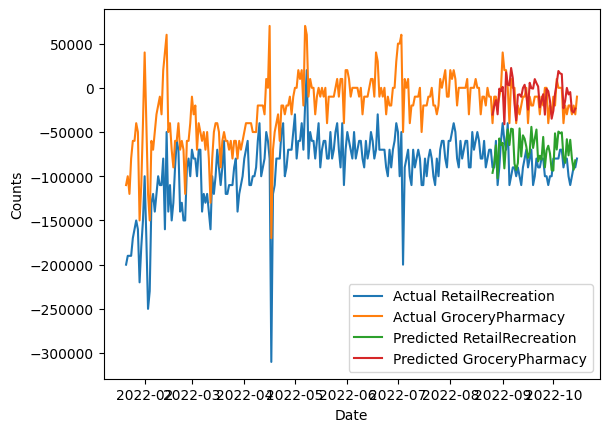

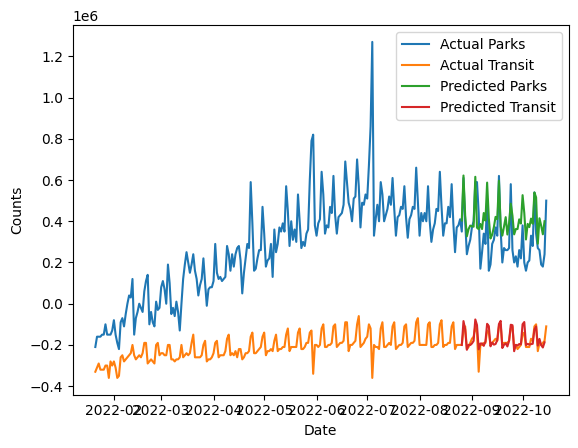

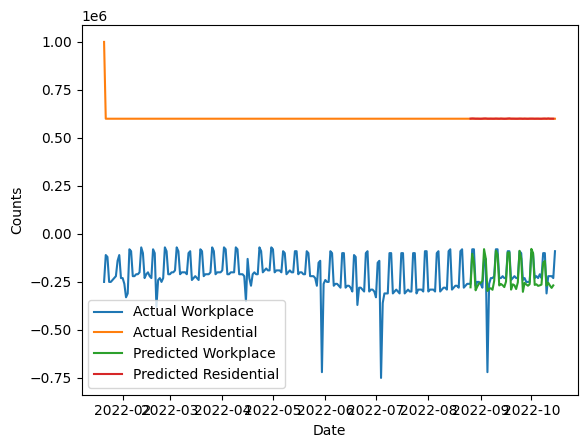

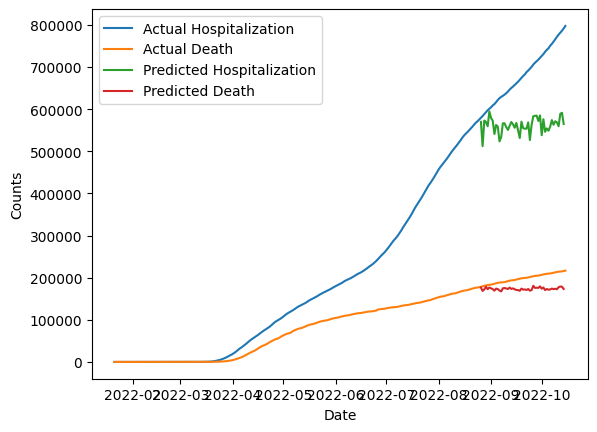

In [56]:
# Define a function to get the next day's input sequence based on the last 'sequence_length' days
def get_next_input_sequence(dataComp, sequence_length):
    last_sequence = dataComp[-sequence_length:]  # Last 'sequence_length' days
    return torch.tensor(last_sequence).float()
#pad = 280000
#pad2 = 50000

pad = 0
pad2 = 0

# Define the number of days to forecast (50 days in this case)
forecast_days = 50
# Set the model to evaluation mode
model.eval()
# Create a list to store the estimated values
estimations = []

# Start forecasting
with torch.no_grad():
    predicted_values1 = []
    predicted_values2 = []
    predicted_values3 = []
    predicted_values4 = []
    predicted_values5 = []
    predicted_values6 = []
    predicted_values7 = []
    predicted_values8 = []



    future_sequence = input_sequences[-1].unsqueeze(0)
    future_sequence = future_sequence.to(device)
    print(future_sequence.shape)
    predicted_values = []

    for day in range(forecast_days):
        next_entity_embedding = entity_embeddings_tensor[day : day + 1]  # Select one entity embedding
        next_relation_embedding = relation_embeddings_tensor  # If this remains constant

        prediction = model(future_sequence, next_entity_embedding, next_relation_embedding)

        predicted_values.append(prediction.squeeze().tolist())

        new_predictions = torch.tensor([predicted_values[-1]]).unsqueeze(0).to(device)
        future_sequence = torch.cat((future_sequence[:, :, 1:], new_predictions.transpose(1, 2)), dim=2)
                



# Denormalize the predicted values
predicted_values = np.array(predicted_values)

predicted_values[:, 0] = (predicted_values[:, 0] * np.std(RetailRecreation)) + np.mean(RetailRecreation)
predicted_values[:, 1] = (predicted_values[:, 1] * np.std(GroceryPharmacy)) + np.mean(GroceryPharmacy)
predicted_values[:, 2] = (predicted_values[:, 2] * np.std(Parks)) + np.mean(Parks)
predicted_values[:, 3] = (predicted_values[:, 3] * np.std(Transit)) + np.mean(Transit)
predicted_values[:, 4] = (predicted_values[:, 4] * np.std(Workplace)) + np.mean(Workplace)
predicted_values[:, 5] = (predicted_values[:, 5] * np.std(Residential)) + np.mean(Residential)
predicted_values[:, 6] = (predicted_values[:, 6] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values[:, 7] = (predicted_values[:, 7] * np.std(Death)) + np.mean(Death)

# Generate dates for the future predictions
start_date = dataComp["Date"].iloc[-1] - pd.Timedelta(days=50)
print("-------------------")
print(start_date)
print("-------------------")

dates = pd.date_range(start=start_date, periods=50)

#dates = pd.date_range(start=(data["Date"].iloc[-1]), periods=daysToPredict)
#names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

plt.plot(dataComp["Date"], dataComp["RetailRecreation"] * 10000, label="Actual RetailRecreation")
plt.plot(dataComp["Date"], dataComp["GroceryPharmacy"] * 10000, label="Actual GroceryPharmacy")

plt.plot(dates, (predicted_values[:, 0]* 10000 ), label="Predicted RetailRecreation")
plt.plot(dates, predicted_values[:, 1]* 10000, label="Predicted GroceryPharmacy")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(dataComp["Date"], dataComp["Parks"] * 10000, label="Actual Parks")
plt.plot(dataComp["Date"], dataComp["Transit"] * 10000, label="Actual Transit")

plt.plot(dates, (predicted_values[:, 2]* 10000 ), label="Predicted Parks")
plt.plot(dates, predicted_values[:, 3]* 10000, label="Predicted Transit")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(dataComp["Date"], dataComp["Workplace"] * 10000, label="Actual Workplace")
plt.plot(dataComp["Date"], dataComp["Residential"] * 100000, label="Actual Residential")

plt.plot(dates, predicted_values[:, 4]* 10000, label="Predicted Workplace")
plt.plot(dates, predicted_values[:, 5]* 100000, label="Predicted Residential")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(dataComp["Date"], (dataComp["Hospitalization"] / 10), label="Actual Hospitalization")
plt.plot(dataComp["Date"], dataComp["Death"], label="Actual Death")

plt.plot(dates, ((predicted_values[:, 6] / 10) + pad), label="Predicted Hospitalization")
plt.plot(dates, predicted_values[:, 7] + pad2, label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226


C:\Users\eddie\AppData\Local\Temp\ipykernel_8688\412941621.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(last_sequence).float()


tensor([[[ 0.4872,  0.7291,  1.2129,  ...,  0.0033,  0.2452,  0.4872],
         [ 0.6348,  0.6348,  1.4123,  ...,  0.8940,  0.6348,  0.8940],
         [ 0.9127,  0.8712,  1.0786,  ...,  0.2489,  0.5808,  0.8712],
         ...,
         [-0.0679, -0.0679, -0.0679,  ..., -0.0679, -0.0679, -0.0679],
         [ 0.4561,  0.4784,  0.5006,  ...,  0.6477,  0.6730,  0.6996],
         [ 0.8540,  0.8583,  0.8638,  ...,  0.9198,  0.9240,  0.9302]],

        [[ 0.7291,  1.2129,  0.9710,  ...,  0.2452,  0.4872, -0.2386],
         [ 0.6348,  1.4123,  1.9306,  ...,  0.6348,  0.8940, -0.4018],
         [ 0.8712,  1.0786,  0.9957,  ...,  0.5808,  0.8712,  0.5393],
         ...,
         [-0.0679, -0.0679, -0.0679,  ..., -0.0679, -0.0679, -0.0679],
         [ 0.4784,  0.5006,  0.5279,  ...,  0.6730,  0.6996,  0.7301],
         [ 0.8583,  0.8638,  0.8845,  ...,  0.9240,  0.9302,  0.9455]],

        [[ 1.2129,  0.9710, -0.2386,  ...,  0.4872, -0.2386, -0.4805],
         [ 1.4123,  1.9306,  1.9306,  ...,  0

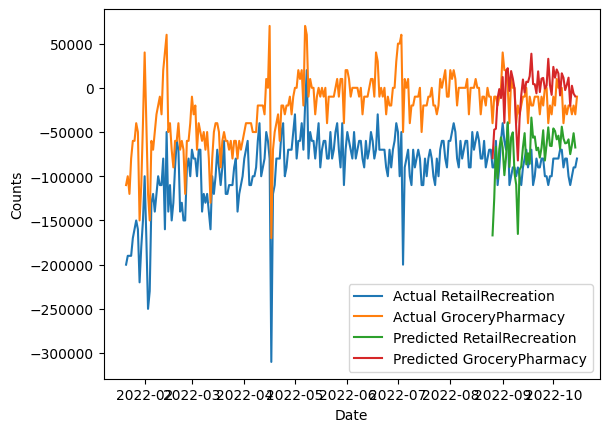

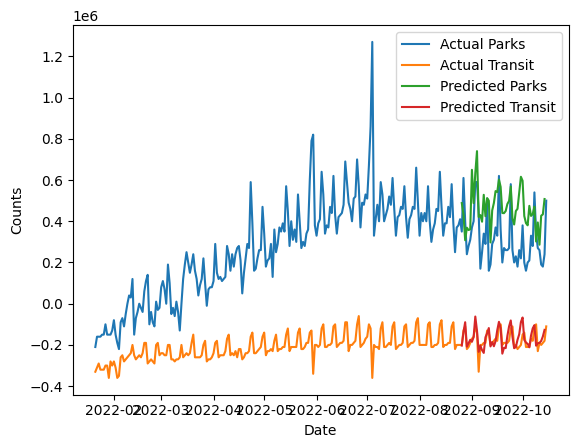

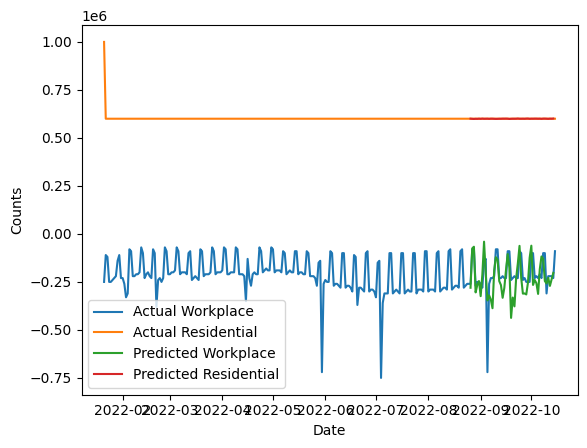

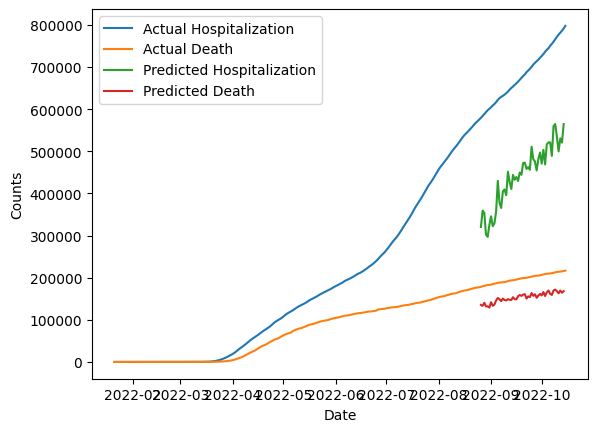

In [31]:
# Define a function to get the next day's input sequence based on the last 'sequence_length' days
def get_next_input_sequence(dataComp, sequence_length):
    last_sequence = dataComp[-sequence_length:]  # Last 'sequence_length' days
    return torch.tensor(last_sequence).float()
#pad = 280000
#pad2 = 50000

pad = 0
pad2 = 0

# Define the number of days to forecast (50 days in this case)
forecast_days = 50
# Set the model to evaluation mode
model.eval()
# Create a list to store the estimated values
estimations = []

# Start forecasting
with torch.no_grad():
    predicted_values1 = []
    predicted_values2 = []
    predicted_values3 = []
    predicted_values4 = []
    predicted_values5 = []
    predicted_values6 = []
    predicted_values7 = []
    predicted_values8 = []

    sequence_length = 50
    input_sequence = input_sequences[-50:]

    future_sequence = input_sequences[-1].unsqueeze(0)  # Use the last input sequence as the initial future sequence
    future_sequence = future_sequence.to(device)

    predicted_values = []


    for day in range(forecast_days):
        ### double check above
        # Prepare the input sequence for the next day
        next_input_sequence = get_next_input_sequence(input_sequence, sequence_length)
        print(next_input_sequence)

        # Move the input sequence to the same device as the model
        next_input_sequence = next_input_sequence.to(device)

        

        # Get the entity and relation embeddings for the next day
        #next_entity_embedding = entity_embeddings_tensor[ (day + 118) - 50 : day + 118]
        next_entity_embedding = entity_embeddings_tensor[ (day ) : day +50]
        ############# FIGURE THIS OUT

        next_relation_embedding = relation_embeddings_tensor

 
        #print(next_input_sequence.shape)
        #print(next_input_sequence.shape)
        #print(next_entity_embedding.shape)
        #print(next_relation_embedding.shape)
        # Generate the prediction for the next day
        #prediction = model(next_input_sequence, next_entity_embedding, next_relation_embedding)
        
        prediction = model(next_input_sequence, next_entity_embedding, next_relation_embedding)

        #print("Input_sequence: ", input_sequence.shape)
        #print("Prediction: ", prediction.shape)

        #input_sequence = torch.cat((input_sequence, prediction))
        input_sequence = torch.cat((input_sequence, prediction.unsqueeze(2)), dim=2)[:, :, 1:]
        
        
        predicted_values1.append(prediction[:, 0].squeeze().tolist())
        predicted_values2.append(prediction[:, 1].squeeze().tolist())
        predicted_values3.append(prediction[:, 2].squeeze().tolist())
        predicted_values4.append(prediction[:, 3].squeeze().tolist())
        predicted_values5.append(prediction[:, 4].squeeze().tolist())
        predicted_values6.append(prediction[:, 5].squeeze().tolist())
        predicted_values7.append(prediction[:, 6].squeeze().tolist())
        predicted_values8.append(prediction[:, 7].squeeze().tolist())

# Convert the estimations list to a numpy array
predicted_values1 = np.array(predicted_values1)
predicted_values2 = np.array(predicted_values2)
predicted_values3 = np.array(predicted_values3)
predicted_values4 = np.array(predicted_values4)
predicted_values5 = np.array(predicted_values5)
predicted_values6 = np.array(predicted_values6)
predicted_values7 = np.array(predicted_values7)
predicted_values8 = np.array(predicted_values8)

predicted_values1[:, 0] = (predicted_values1[:, 0] * np.std(RetailRecreation)) + np.mean(RetailRecreation)
predicted_values2[:, 0] = (predicted_values2[:, 0] * np.std(GroceryPharmacy)) + np.mean(GroceryPharmacy)
predicted_values3[:, 0] = (predicted_values3[:, 0] * np.std(Parks)) + np.mean(Parks)
predicted_values4[:, 0] = (predicted_values4[:, 0] * np.std(Transit)) + np.mean(Transit)
predicted_values5[:, 0] = (predicted_values5[:, 0] * np.std(Workplace)) + np.mean(Workplace)
predicted_values6[:, 0] = (predicted_values6[:, 0] * np.std(Residential)) + np.mean(Residential)

predicted_values7[:, 0] = (predicted_values7[:, 0] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values8[:, 0] = (predicted_values8[:, 0] * np.std(Death)) + np.mean(Death)

# Generate dates for the future predictions
start_date = dataComp["Date"].iloc[-1] - pd.Timedelta(days=50)
print("-------------------")
print(start_date)
print("-------------------")

dates = pd.date_range(start=start_date, periods=50)

#dates = pd.date_range(start=(data["Date"].iloc[-1]), periods=daysToPredict)
#names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

plt.plot(dataComp["Date"], dataComp["RetailRecreation"] * 10000, label="Actual RetailRecreation")
plt.plot(dataComp["Date"], dataComp["GroceryPharmacy"] * 10000, label="Actual GroceryPharmacy")

plt.plot(dates, (predicted_values1[:, 0]* 10000 ), label="Predicted RetailRecreation")
plt.plot(dates, predicted_values2[:, 0]* 10000, label="Predicted GroceryPharmacy")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(dataComp["Date"], dataComp["Parks"] * 10000, label="Actual Parks")
plt.plot(dataComp["Date"], dataComp["Transit"] * 10000, label="Actual Transit")

plt.plot(dates, (predicted_values3[:, 0]* 10000 ), label="Predicted Parks")
plt.plot(dates, predicted_values4[:, 0]* 10000, label="Predicted Transit")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(dataComp["Date"], dataComp["Workplace"] * 10000, label="Actual Workplace")
plt.plot(dataComp["Date"], dataComp["Residential"] * 100000, label="Actual Residential")

plt.plot(dates, predicted_values5[:, 0]* 10000, label="Predicted Workplace")
plt.plot(dates, predicted_values6[:, 0]* 100000, label="Predicted Residential")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(dataComp["Date"], (dataComp["Hospitalization"] / 10), label="Actual Hospitalization")
plt.plot(dataComp["Date"], dataComp["Death"], label="Actual Death")

plt.plot(dates, ((predicted_values7[:, 0] / 10) + pad), label="Predicted Hospitalization")
plt.plot(dates, predicted_values8[:, 0] + pad2, label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226


## Connecting to Neo4j via py2neo

In [32]:
from py2neo import Graph
import re

from neo4j import GraphDatabase
from datetime import datetime
# Connect to the Neo4j database
# Remember to change password to your own when running the program. 
driver = Graph("bolt://localhost:7687", user="neo4j", password="Texaco10?123")

# Cypher query to retrieve mobility data
query = """
MATCH (d:Date)-[:has_Retail]->(retail:Mobility),
      (d)-[:has_Grocery]->(grocery:Mobility),
      (d)-[:has_Parks]->(parks:Mobility),
      (d)-[:has_Transit]->(transit:Mobility),
      (d)-[:has_Workplaces]->(workplaces:Mobility),
      (d)-[:has_Residential]->(residential:Mobility),
      (d)-[:has_Hospitalizations]->(hospitalizations:HealthData),
      (d)-[:has_Deaths]->(deaths:HealthData)
RETURN d.date AS date,
       retail.percent_change AS retail_change,
       grocery.percent_change AS grocery_change,
       parks.percent_change AS parks_change,
       transit.percent_change AS transit_change,
       workplaces.percent_change AS workplaces_change,
       residential.percent_change AS residential_change,
       hospitalizations.value AS hospitalizations,
       deaths.value AS deaths
"""
# Execute the query
mobility_data = driver.run(query)



dates = [row["date"] for row in mobility_data]
mobility_data = driver.run(query)
retail_changes = [row["retail_change"] for row in mobility_data]
mobility_data = driver.run(query)
grocery_changes = [row["grocery_change"] for row in mobility_data]
mobility_data = driver.run(query)
parks_changes = [row["parks_change"] for row in mobility_data]
mobility_data = driver.run(query)
transit_changes = [row["transit_change"] for row in mobility_data]
mobility_data = driver.run(query)
workplaces_changes = [row["workplaces_change"] for row in mobility_data]
mobility_data = driver.run(query)
residential_changes = [row["residential_change"] for row in mobility_data]
mobility_data = driver.run(query)
hospitalizations = [row["hospitalizations"] for row in mobility_data]
mobility_data = driver.run(query)
deaths = [row["deaths"] for row in mobility_data]


# Print or use the data as needed
print("Dates:", dates)
print("Retail Changes:", retail_changes)
print("Grocery Changes:", grocery_changes)
print("Parks Changes:", parks_changes)
print("Transit Changes:", transit_changes)
print("Workplaces Changes:", workplaces_changes)
print("Residential Changes:", residential_changes)
print("Hospitalizations:", hospitalizations)
print("Deaths:", deaths)

# Process the results and store them in a dictionary
#data = {}
#for record in result:
#    date = record["date"]
#    print(date)
#    attribute = record["attribute"]
#    print(attribute)
#    percent_change = record["percent_change"]
#
#    if date not in data:
#        data[date] = {}
#
#    data[date][attribute] = percent_change
#
#print(data['2022-05-01'])

# Extract the date string within the parentheses
#date_string = date_value[date_value.find("(") + 1 : date_value.find(")")]
#date_string = pd.to_datetime(date_string)

# Parse the date string

#print(date_string)
#relation1 = [row['relationship'] for row in results]
#tail1 = [row['english_word'] for row in results]
#print(mortality)
#print(infectiousness)

## block tensor decomposition Tensorly, match sizes (filter)
# WBK 


ConnectionUnavailable: Cannot open connection to ConnectionProfile('bolt://localhost:7687')

## Historic Code Below

In [ ]:
#import torch
#import torch.nn as nn
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#
## Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
#data = pd.read_csv("us.csv", header=None, names=["Date", "Hospitalization", "Death"])
#
## Convert the "Date" column to a pandas DateTime object
#data["Date"] = pd.to_datetime(data["Date"])
#
## Sort the data by date if it's not already sorted
#data.sort_values("Date", inplace=True)
#
## Extract the values as numpy arrays
#Hospitalization = data["Hospitalization"].values.astype(float)
#Death = data["Death"].values.astype(float)
#
## Normalize the data
#normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
#normalized_Death = (Death - np.mean(Death)) / np.std(Death)
#
## Define the sequence length and number of features
#sequence_length = 100  # Number of previous days to consider
#num_features = 2  # Number of input features (Value1 and Value2)
#
## Create input sequences and corresponding targets
#input_sequences = []
#targets = []
#
### all input - sequence length last days
#for i in range(len(normalized_Hospitalization) - sequence_length):
#    seq = np.array([normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
#    input_sequences.append(seq)
#    targets.append([normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])
#
## Convert the input sequences and targets to PyTorch tensors
#input_sequences = torch.tensor(input_sequences).float()
#targets = torch.tensor(targets).float()
#
#class RNN(nn.Module):
#    def __init__(self, input_size, hidden_size, num_layers, output_size):
#        super(RNN, self).__init__()
#        self.hidden_size = hidden_size
#        self.num_layers = num_layers
#        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#        out, _ = self.rnn(x, h0[:, :x.size(0), :])
#        out = self.fc(out[:, -1, :])
#        return out
#
## Define the hyperparameters
#input_size = sequence_length
#hidden_size = 64
#num_layers = 2
#output_size = num_features
#
## Create an instance of the RNN model
#model = RNN(input_size, hidden_size, num_layers, output_size)
#
## Define the loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
## Set the device (GPU if available, otherwise CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
## Move the input sequences and targets to the device
#input_sequences = input_sequences.to(device)
#targets = targets.to(device)
#
## Move the model to the device
#model = model.to(device)
#
## ... previous code ...
#
## Set the number of training epochs
#num_epochs = 10000
#
## Define the loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
## Set the device (GPU if available, otherwise CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
## Move the input sequences and targets to the device
#input_sequences = input_sequences.to(device)
#targets = targets.to(device)
#
## Move the model to the device
#model = model.to(device)
#
## Training loop
#for epoch in range(num_epochs):
#    model.train()
#    outputs = model(input_sequences)
#    loss = criterion(outputs, targets)
#
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()
#
#    if (epoch + 1) % 100 == 0:
#        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
#

# Convert the entity and relation embeddings to torch tensors
entity_embeddings_tensor = torch.tensor(entity_embeddings).to(device)
print(entity_embeddings_tensor.shape)
print(input_sequences.shape)

# Given shapes

# Step 1: Expand the entity_embeddings_tensor to match the shape of input_sequences
num_sequences = input_sequences.shape[2]
sliced_entity_embeddings = entity_embeddings_tensor[:, :, None].expand(-1, -1, num_sequences)

# Concatenate the sliced entity embeddings with the input_sequences along axis 1
input_sequences_with_entities = torch.cat([input_sequences, sliced_entity_embeddings], dim=1)

# The final shape of input_sequences_with_entities will be torch.Size([168, 8, 50])
print(input_sequences_with_entities.shape)




In [ ]:
# Switch the model to evaluation mode
model.eval()

# ... previous code ...
daysToPredict = 50

# Generate predictions
with torch.no_grad():
    future_sequence = input_sequences[-1].unsqueeze(0)  # Use the last input sequence as the initial future sequence
    future_sequence = future_sequence.to(device)

    predicted_values = []

    for _ in range(daysToPredict):  
        predictions = model(future_sequence, entity_embeddings_tensor, relation_embeddings_tensor)
        predicted_values.append(predictions.squeeze().tolist())

        # Update the future sequence by removing the first input and appending the new predictions
        new_predictions = torch.tensor([predicted_values[-1]]).unsqueeze(0).to(device)
        future_sequence = torch.cat((future_sequence[:, :, 1:], new_predictions.transpose(1, 2)), dim=2)

# Denormalize the predicted values
predicted_values = np.array(predicted_values)

predicted_values[:, 0] = (predicted_values[:, 0] * np.std(RetailRecreation)) + np.mean(RetailRecreation)
predicted_values[:, 1] = (predicted_values[:, 1] * np.std(GroceryPharmacy)) + np.mean(GroceryPharmacy)
predicted_values[:, 2] = (predicted_values[:, 2] * np.std(Parks)) + np.mean(Parks)
predicted_values[:, 3] = (predicted_values[:, 3] * np.std(Transit)) + np.mean(Transit)
predicted_values[:, 4] = (predicted_values[:, 4] * np.std(Workplace)) + np.mean(Workplace)
predicted_values[:, 5] = (predicted_values[:, 5] * np.std(Residential)) + np.mean(Residential)
predicted_values[:, 6] = (predicted_values[:, 6] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values[:, 7] = (predicted_values[:, 7] * np.std(Death)) + np.mean(Death)


# Generate dates for the future predictions
start_date = data["Date"].iloc[-1] - pd.Timedelta(days=50)

dates = pd.date_range(start=start_date, periods=daysToPredict)



#dates = pd.date_range(start=(data["Date"].iloc[-1]), periods=daysToPredict)
#names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])


plt.plot(data["Date"], data["RetailRecreation"] * 10000, label="Actual RetailRecreation")
plt.plot(data["Date"], data["GroceryPharmacy"] * 10000, label="Actual GroceryPharmacy")

plt.plot(dates, (predicted_values[:, 0]* 10000 ), label="Predicted RetailRecreation")
plt.plot(dates, predicted_values[:, 1]* 10000, label="Predicted GroceryPharmacy")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], data["Parks"] * 10000, label="Actual Parks")
plt.plot(data["Date"], data["Transit"] * 10000, label="Actual Transit")

plt.plot(dates, (predicted_values[:, 2]* 10000 ), label="Predicted Parks")
plt.plot(dates, predicted_values[:, 3]* 10000, label="Predicted Transit")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], data["Workplace"] * 10000, label="Actual Workplace")
plt.plot(data["Date"], data["Residential"] * 100000, label="Actual Residential")

plt.plot(dates, predicted_values[:, 4]* 10000, label="Predicted Workplace")
plt.plot(dates, predicted_values[:, 5]* 100000, label="Predicted Residential")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

# Plot the actual values and predicted values
plt.plot(data["Date"], (data["Hospitalization"] / 10), label="Actual Hospitalization")
plt.plot(data["Date"], data["Death"], label="Actual Death")

plt.plot(dates, (predicted_values[:, 6] / 10), label="Predicted Hospitalization")
plt.plot(dates, predicted_values[:, 7], label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226





# implementing 
# formalize knowledge idea partial data and built up models on top
# human inspired machine learning computerize idea of 1000 brains. 
# dr tianmen liu pre print. 
# https://www.researchgate.net/publication/369592298_When_Brain-inspired_AI_Meets_AGI
# https://www.numenta.com/resources/research-publications/papers/

# 
# compile lots of features. 
# R not test bed perdiction only RNN. 
# Knowledge embedding
# BTD is for knowledge embedding
# 


In [ ]:
        # Get the last 'sequence_length' days of the existing data

        # Get the last 'sequence_length' days of the existing data for the input sequence
        #last_sequence_data = input_sequences[-sequence_length:]

        # Prepare the input sequence for the next day
        #next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)

        # Move the input sequence to the same device as the model
        #next_input_sequence = next_input_sequence.to(device)
        #next_input_sequence = next_input_sequence.squeeze(0)
        
#########################

        # Get the last 'sequence_length' days of the existing data for the input sequence
        last_sequence_data = input_sequences[-sequence_length:]

        # Prepare the input sequence for the next day
        #next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)

        # Move the input sequence to the same device as the model
        #next_input_sequence = next_input_sequence.to(device)
        
#########################
        #last_sequence_data = input_sequences[-1]
        ### double check above
        # Prepare the input sequence for the next day
        next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)
        next_input_sequence = next_input_sequence.squeeze(0)

        # Move the input sequence to the same device as the model
        next_input_sequence = next_input_sequence.to(device)

        # Get the entity and relation embeddings for the next day
        #next_entity_embedding = entity_embeddings_tensor[day:day + forecast_days ]
        next_entity_embedding = entity_embeddings_tensor[day + 118].unsqueeze(0)
        ############# FIGURE THIS OUT
